## Final Project 4 - Predictive Model

**Introduction**
In the previous notebook, we explored different features of our data. 
So far, our findings show that unit type and day of the week have a significant influence over the callback volume.

Additionally, after a t-test, we were unable to reject the null hypothesis that a number of weather conditions can influence whether a given unit will have a callback on the next visit.

**Model**
For our non-aggregated data, we will evaluate a Random Forest Classifier Model. This will allow us to not only evaluate the predictive power of each feature so that we can optimize our predictions, but also (hopefully) give us a decent forecast of the callbacks to come.

Moving forward, we will use the data from our previous notebook. The only difference in this data from the data we loaded at the beginning of the other notebook is that this data includes peak to peak values of our weather conditions.

In [1]:
#import modules and dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_pickle('pickles/df_final_notebook')
df.sort_values('reported',inplace=True)
df.index = range(0,len(df))
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'pickles/df_final_notebook'

##### Split the Data
Below we will divide our data into "input" and "output" data.
The input data is what we will use as an input to our model. The output data is what we will attempt to predict (whether a unit will have a callback on a particular date).

In [2]:
#create our input data
incols = df.columns.tolist()
for col in ['cb','pm','si','usid','reported','lastVisit']:
    incols.remove(col)

dfInput = df[incols]
dfOutput = df.cb
dfInput.head()

,maxTemp,meanTemp,minTemp,maxHum,meanHum,minHum,maxPres,meanPres,minPres,maxDew,...,pmlast,rprlast,silast,daysSince,wkdRpt,wkdLv,p2pTemp,p2pHum,p2pPres,p2pDew
0,77.0,66.0,55.0,86.0,61.0,36.0,30.35,30.17,30.11,58.0,...,0.0,0.0,0.0,0.0,0,0.0,22.0,50.0,0.24,12.0
1,77.0,66.0,55.0,86.0,61.0,36.0,30.35,30.17,30.11,58.0,...,0.0,0.0,0.0,0.0,0,0.0,22.0,50.0,0.24,12.0
2,77.0,66.0,55.0,86.0,61.0,36.0,30.35,30.17,30.11,58.0,...,0.0,0.0,0.0,0.0,0,0.0,22.0,50.0,0.24,12.0
3,77.0,66.0,55.0,86.0,61.0,36.0,30.35,30.17,30.11,58.0,...,0.0,0.0,0.0,0.0,0,0.0,22.0,50.0,0.24,12.0
4,77.0,66.0,55.0,86.0,61.0,36.0,30.35,30.17,30.11,58.0,...,0.0,0.0,0.0,0.0,0,0.0,22.0,50.0,0.24,12.0


#### Feature importance
Next we will divide our input/output variables into test and training sets and train our model.
Before getting too elaborate, we will run a simple model with only 10 trees and evaluate feature importance. Doing so, we can remove any irrelevent features

In [3]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10)

xTrain = dfInput.iloc[0:-200] 
yTrain = dfOutput.iloc[0:-200]
xTest = dfInput.iloc[-200:].copy()
yTest = dfOutput.iloc[-200:].copy()
forest.fit(xTrain,yTrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now that the model has been fit, we can evaluate feature importances.

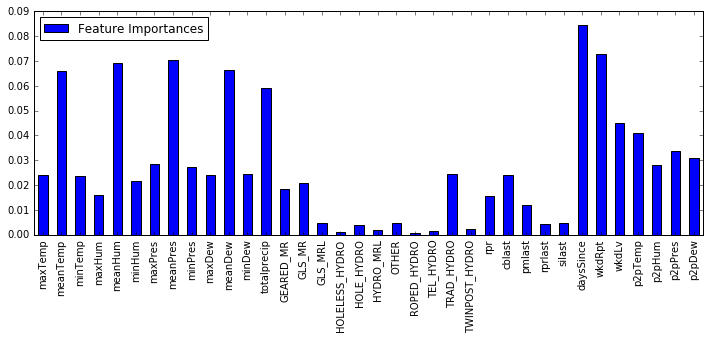

In [4]:
%matplotlib inline
dfFeatureImportances = pd.DataFrame(index=xTest.columns,columns=['Feature Importances'],data=forest.feature_importances_)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
dfFeatureImportances.plot(kind='bar',ax=ax)

It looks like on a more granular level, the individual unit type does not matter as much as our other features.

Let's try again, but this time we will drop any features with a relative importance below (0.02). To keep things simple, we will drop all unit types as well.

In [5]:
dropList = []
for ftr in dfFeatureImportances['Feature Importances'].index:
    if dfFeatureImportances['Feature Importances'][ftr] < 0.02:
        dropList.append(ftr)
        
dfFeatureImportances.drop(dropList,inplace=True)

Now drop unit types

In [6]:
dfFeatureImportances.drop(['GLS_MR','TRAD_HYDRO'],inplace=True)

Retrain our model using the fetures which we determine were most relevent.
This time, we'll train on fewer features to prevent over-fitting.

In [8]:
keepList = dfFeatureImportances.index.tolist()

forest = RandomForestClassifier(n_estimators=10)

xTrain = dfInput[keepList].iloc[0:-500] 
yTrain = dfOutput.iloc[0:-500]
xTest = dfInput[keepList].iloc[-500:].copy()
yTest = dfOutput.iloc[-500:].copy()
forest.fit(xTrain,yTrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Re-evaluate Feature importance

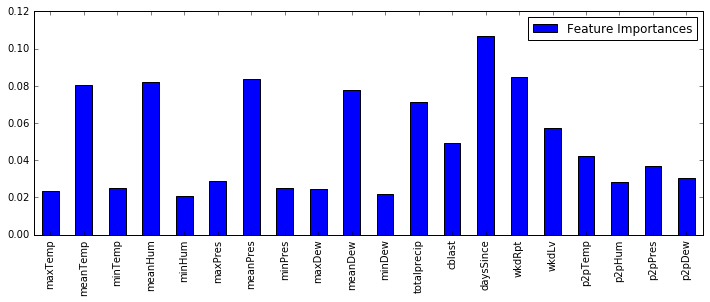

In [9]:
dfFeatureImportances = pd.DataFrame(index=xTest.columns,columns=['Feature Importances'],data=forest.feature_importances_)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
dfFeatureImportances.plot(kind='bar',ax=ax)

Now let's evaluate the model

In [10]:
def f1Score(yTest,preds):
    yTest.index=range(0,len(yTest))
    evalDict = dict({'preds':preds,'actuals':yTest})
    dfEval = pd.DataFrame(data=evalDict)

    tp = 0.
    fp = 0.
    tn = 0.
    fn = 0.

    for a in dfEval['actuals']:
        for p in dfEval['preds']:
            if a == 1 and np.round(p) == 1:
                tp += 1
            if a == 1 and np.round(p) == 0:
                fn += 1
            if a == 0 and np.round(p) == 1:
                fp += 1
            if a == 0 and np.round(p) == 0:
                tn +=1

    acc = (tp+tn)/(tp+fn+fp+tn)
    f1score = 2*tp/(2*tp+fn+fp)
    print 'tpr', tp/(tp+tn)
    print 'fpr', fp/(fp+tn)
    print 'acc', (tp+fn)/(tp+fn+tn+fp)
    return f1score

In [12]:
preds = forest.predict(xTest)
f1Score(yTest,preds)

tpr 0.0754138565297
fpr 0.2
acc 0.246


0.22062780269058296

Our accuracy is only 24.6%... Let's drop a few more features and try again.

In [19]:
dropList = []
for ftr in dfFeatureImportances['Feature Importances'].index:
    if dfFeatureImportances['Feature Importances'][ftr] < 0.03:
        dropList.append(ftr)
        
dfFeatureImportances.drop(dropList,inplace=True)

In [20]:
keepList = dfFeatureImportances.index.tolist()

forest = RandomForestClassifier(n_estimators=10)

xTrain = dfInput[keepList].iloc[0:-500] 
yTrain = dfOutput.iloc[0:-500]
xTest = dfInput[keepList].iloc[-500:].copy()
yTest = dfOutput.iloc[-500:].copy()
forest.fit(xTrain,yTrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
preds=forest.predict(xTest)
f1Score(yTest,preds)

tpr 0.0552495330859
fpr 0.152
acc 0.246


0.18789949748743717

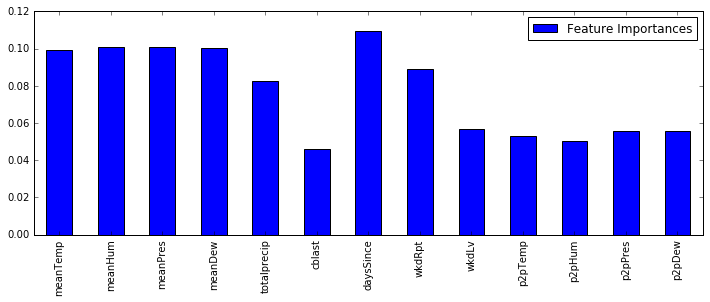

In [22]:
dfFeatureImportances = pd.DataFrame(index=xTest.columns,columns=['Feature Importances'],data=forest.feature_importances_)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
dfFeatureImportances.plot(kind='bar',ax=ax)

It seems that last iteration actually made it worse.

We'll try once more, but this time, after dropping more features, we will increase the number of estimators from 10 to 100, as well as change our train/test split

In [29]:
dropList = []
for ftr in dfFeatureImportances['Feature Importances'].index:
    if dfFeatureImportances['Feature Importances'][ftr] < 0.06:
        dropList.append(ftr)
        
dfFeatureImportances.drop(dropList,inplace=True)

tpr 0.0126582278481
fpr 0.142857142857
acc 0.0714285714286


0.09523809523809523

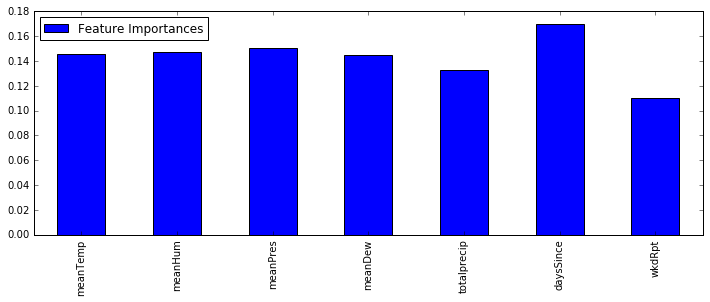

In [30]:
keepList = dfFeatureImportances.index.tolist()

forest = RandomForestClassifier(n_estimators=100)

xTrain = dfInput[keepList].iloc[0:-70] 
yTrain = dfOutput.iloc[0:-70]
xTest = dfInput[keepList].iloc[-70:].copy()
yTest = dfOutput.iloc[-70:].copy()
forest.fit(xTrain,yTrain)

dfFeatureImportances = pd.DataFrame(index=xTest.columns,columns=['Feature Importances'],data=forest.feature_importances_)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
dfFeatureImportances.plot(kind='bar',ax=ax)

preds=forest.predict(xTest)
f1Score(yTest,preds)

### Random Forest Classifier - Conclusions
After trying a number of different configurations, it seems like a Random forest classifier is not the appropriate model for this kind of prediction. It is possible that the weather does not play a big enough role in the callback volume to make predictions on individual units. For something as granular as this, we likely will need more unit-specific data which describes the actual operating and use conditions of a given unit.

We will continue our evaluation looking at regression models for our forecasting

### Regression Models

Because it seems to be too difficult to predict callbacks on an individual basis, we will attempt to use a regression model to make predictions of callback volume for the entire city.

Because we have many features which are likely related to one another in a non-linear manner, we will use a Random Forest Regressor. However our current data cannot be used for this model. We will have to use our daily aggregates from the previous notebook

In [46]:
df2 = pd.read_pickle('pickles/dff_pickle')
dfInput = df2[df2.columns[0:5]]
dfOutput = df2['cb']
df2.head()

,meanTemp,meanPres,meanDew,meanHum,wkd,cb
0,75,30.11,47,46,2,43
1,76,29.96,47,49,3,36
2,75,29.92,45,41,4,35
3,74,30.07,52,57,5,3
4,74,30.03,49,51,6,18


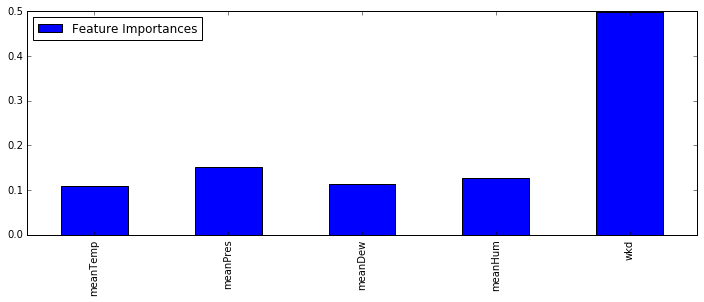

In [57]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=3000)

xTrain = dfInput.iloc[0:-100] #train with all data before 2016
yTrain = dfOutput.iloc[0:-100]#.ravel().vaulues()
xTest = dfInput.iloc[-100:].copy()
yTest = dfOutput.iloc[-100:].copy()
forest.fit(xTrain,yTrain)

dfFeatureImportances = pd.DataFrame(index=xTest.columns,columns=['Feature Importances'],data=forest.feature_importances_)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
dfFeatureImportances.plot(kind='bar',ax=ax)

Strangely enough, we find that the most important feature of what we have left is weekday.

**Next, we can evaluate our prediction errors**

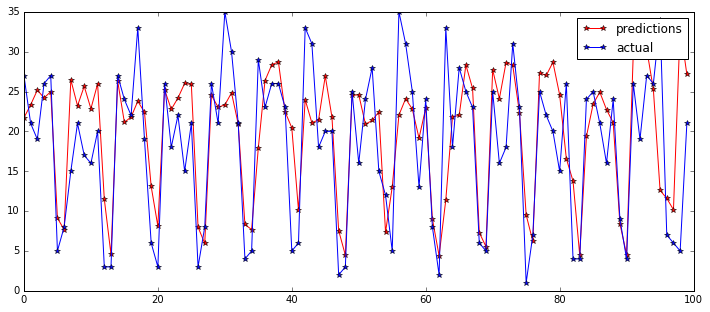

In [58]:
preds = forest.predict(xTest)
actuals = yTest.copy()
actuals.index = range(0,len(actuals))

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(preds,'r*-')
ax1.plot(actuals,'b*-')
ax1.legend(['predictions','actual'])

5.26030666667


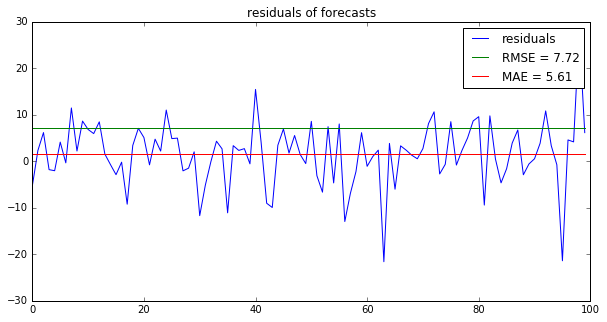

In [59]:
diffs = (preds.T-actuals.T)
#diffs.index = [0]
diffs = np.array(diffs.T)

def rmse(diffs):
    
    den = np.float(len(diffs))
    num = 0.
    for m in diffs:
        num += m**2
    return (num/den)**.5

print np.mean(np.abs(diffs))

fig=  plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(diffs)
ax.plot(np.ones(len(diffs))*rmse(diffs))
ax.plot(np.ones(len(diffs))*np.mean(diffs))
ax.set_title('residuals of forecasts')
ax.legend(['residuals','RMSE = 7.72','MAE = 5.61'])
#plt.plot(diffs.values,'r*-')

### Random Forest Regressor - Conclusions

While the errors were a bit high, the Random Forest regressor actually captured the general pattern of the callbacks very well. 

It is very possible that any predictive power we have through this model is coming solely from the day of the week. 

### Next steps:

1. Try to find more unit-specific data for each elevator we service. It's very ambitious, but in order to predict callbacks on this low of a level, we will likely need to log data on each unit for several years.

2. Explore other variables which may influence the callback volume for the entire city - this seems more promising in the short-term.